In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,), std=(0.5,))])

# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)


batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



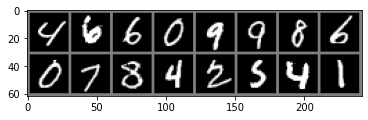

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

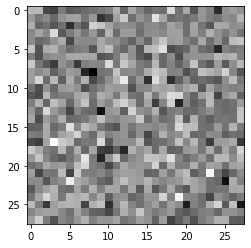

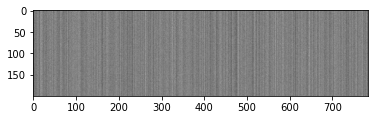

In [4]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [5]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.5081, 0.5139, 0.5165, 0.5114, 0.5168]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [6]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):

    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #

        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #

        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()

        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.


    return p_real, p_fake

(epoch 1/200) p_real: 0.997928, p_g: 0.004886
(epoch 2/200) p_real: 0.997201, p_g: 0.000661
(epoch 3/200) p_real: 0.999391, p_g: 0.001536
(epoch 4/200) p_real: 0.994534, p_g: 0.003911
(epoch 5/200) p_real: 0.996100, p_g: 0.008051
(epoch 6/200) p_real: 0.971703, p_g: 0.067638
(epoch 7/200) p_real: 0.989382, p_g: 0.039982
(epoch 8/200) p_real: 0.994513, p_g: 0.004829
(epoch 9/200) p_real: 0.988500, p_g: 0.042633
(epoch 10/200) p_real: 0.976537, p_g: 0.026659


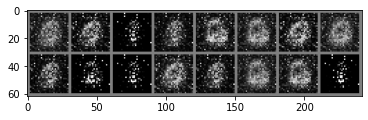

(epoch 11/200) p_real: 0.922251, p_g: 0.071933
(epoch 12/200) p_real: 0.951802, p_g: 0.028936
(epoch 13/200) p_real: 0.992978, p_g: 0.013842
(epoch 14/200) p_real: 0.943425, p_g: 0.020877
(epoch 15/200) p_real: 0.957278, p_g: 0.041625
(epoch 16/200) p_real: 0.945102, p_g: 0.072970
(epoch 17/200) p_real: 0.891689, p_g: 0.043129
(epoch 18/200) p_real: 0.853261, p_g: 0.117770
(epoch 19/200) p_real: 0.936519, p_g: 0.043216
(epoch 20/200) p_real: 0.944329, p_g: 0.081865


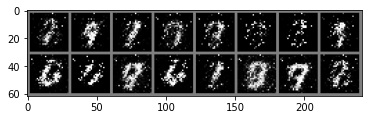

(epoch 21/200) p_real: 0.863149, p_g: 0.101504
(epoch 22/200) p_real: 0.896771, p_g: 0.077395
(epoch 23/200) p_real: 0.863628, p_g: 0.150619
(epoch 24/200) p_real: 0.869885, p_g: 0.139183
(epoch 25/200) p_real: 0.887341, p_g: 0.057431
(epoch 26/200) p_real: 0.881162, p_g: 0.100139
(epoch 27/200) p_real: 0.883161, p_g: 0.163145
(epoch 28/200) p_real: 0.873791, p_g: 0.137967
(epoch 29/200) p_real: 0.855891, p_g: 0.097958
(epoch 30/200) p_real: 0.873108, p_g: 0.095519


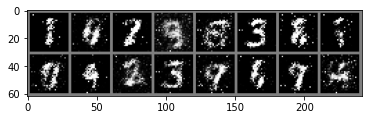

(epoch 31/200) p_real: 0.833811, p_g: 0.093871
(epoch 32/200) p_real: 0.813015, p_g: 0.127782
(epoch 33/200) p_real: 0.807040, p_g: 0.151077
(epoch 34/200) p_real: 0.776946, p_g: 0.070146
(epoch 35/200) p_real: 0.812305, p_g: 0.146955
(epoch 36/200) p_real: 0.808663, p_g: 0.190722
(epoch 37/200) p_real: 0.811252, p_g: 0.177314
(epoch 38/200) p_real: 0.817530, p_g: 0.232841
(epoch 39/200) p_real: 0.853647, p_g: 0.167357
(epoch 40/200) p_real: 0.799771, p_g: 0.150737


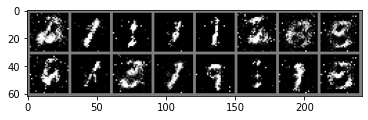

(epoch 41/200) p_real: 0.812132, p_g: 0.142758
(epoch 42/200) p_real: 0.807085, p_g: 0.207217
(epoch 43/200) p_real: 0.750437, p_g: 0.174755
(epoch 44/200) p_real: 0.804858, p_g: 0.183998
(epoch 45/200) p_real: 0.740590, p_g: 0.180336
(epoch 46/200) p_real: 0.765335, p_g: 0.147500
(epoch 47/200) p_real: 0.771102, p_g: 0.196954
(epoch 48/200) p_real: 0.802368, p_g: 0.215695
(epoch 49/200) p_real: 0.761231, p_g: 0.194084
(epoch 50/200) p_real: 0.733808, p_g: 0.182800


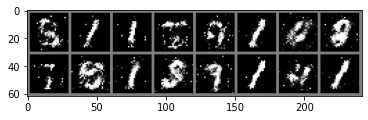

(epoch 51/200) p_real: 0.754385, p_g: 0.213904
(epoch 52/200) p_real: 0.718874, p_g: 0.169845
(epoch 53/200) p_real: 0.753096, p_g: 0.203139
(epoch 54/200) p_real: 0.724107, p_g: 0.207951
(epoch 55/200) p_real: 0.709650, p_g: 0.191023
(epoch 56/200) p_real: 0.689880, p_g: 0.195276
(epoch 57/200) p_real: 0.679011, p_g: 0.209256
(epoch 58/200) p_real: 0.725743, p_g: 0.196846
(epoch 59/200) p_real: 0.735865, p_g: 0.196411
(epoch 60/200) p_real: 0.688359, p_g: 0.207093


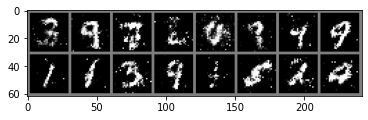

(epoch 61/200) p_real: 0.682355, p_g: 0.200656
(epoch 62/200) p_real: 0.688964, p_g: 0.239801
(epoch 63/200) p_real: 0.687762, p_g: 0.239572
(epoch 64/200) p_real: 0.743101, p_g: 0.325228
(epoch 65/200) p_real: 0.684055, p_g: 0.253513
(epoch 66/200) p_real: 0.674381, p_g: 0.230657
(epoch 67/200) p_real: 0.644159, p_g: 0.236868
(epoch 68/200) p_real: 0.725847, p_g: 0.292270
(epoch 69/200) p_real: 0.654935, p_g: 0.223131
(epoch 70/200) p_real: 0.677317, p_g: 0.308540


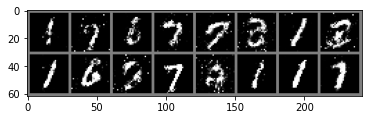

(epoch 71/200) p_real: 0.674727, p_g: 0.248654
(epoch 72/200) p_real: 0.658166, p_g: 0.240224
(epoch 73/200) p_real: 0.627251, p_g: 0.227425
(epoch 74/200) p_real: 0.624480, p_g: 0.153671
(epoch 75/200) p_real: 0.668936, p_g: 0.250011
(epoch 76/200) p_real: 0.671757, p_g: 0.262863
(epoch 77/200) p_real: 0.664302, p_g: 0.278240
(epoch 78/200) p_real: 0.629445, p_g: 0.240107
(epoch 79/200) p_real: 0.662816, p_g: 0.282448
(epoch 80/200) p_real: 0.629375, p_g: 0.229863


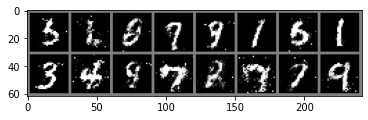

(epoch 81/200) p_real: 0.668878, p_g: 0.279199
(epoch 82/200) p_real: 0.613065, p_g: 0.213179
(epoch 83/200) p_real: 0.647845, p_g: 0.248297
(epoch 84/200) p_real: 0.646951, p_g: 0.269588
(epoch 85/200) p_real: 0.666413, p_g: 0.289413
(epoch 86/200) p_real: 0.635560, p_g: 0.252999
(epoch 87/200) p_real: 0.665804, p_g: 0.258292
(epoch 88/200) p_real: 0.641347, p_g: 0.260589
(epoch 89/200) p_real: 0.660557, p_g: 0.261219
(epoch 90/200) p_real: 0.690214, p_g: 0.295877


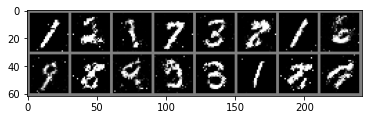

(epoch 91/200) p_real: 0.682568, p_g: 0.272350
(epoch 92/200) p_real: 0.657990, p_g: 0.279694
(epoch 93/200) p_real: 0.653528, p_g: 0.331184
(epoch 94/200) p_real: 0.623985, p_g: 0.216179
(epoch 95/200) p_real: 0.627670, p_g: 0.313412
(epoch 96/200) p_real: 0.634116, p_g: 0.271670
(epoch 97/200) p_real: 0.681461, p_g: 0.323767
(epoch 98/200) p_real: 0.613286, p_g: 0.248228
(epoch 99/200) p_real: 0.611945, p_g: 0.280151
(epoch 100/200) p_real: 0.665933, p_g: 0.302571


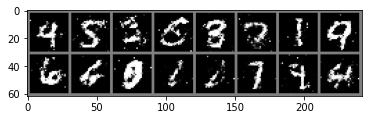

(epoch 101/200) p_real: 0.641916, p_g: 0.315288
(epoch 102/200) p_real: 0.600170, p_g: 0.233672
(epoch 103/200) p_real: 0.677916, p_g: 0.365299
(epoch 104/200) p_real: 0.616284, p_g: 0.275547
(epoch 105/200) p_real: 0.656396, p_g: 0.303314
(epoch 106/200) p_real: 0.618064, p_g: 0.298097
(epoch 107/200) p_real: 0.676050, p_g: 0.318490
(epoch 108/200) p_real: 0.607585, p_g: 0.254317
(epoch 109/200) p_real: 0.654781, p_g: 0.327388
(epoch 110/200) p_real: 0.665662, p_g: 0.301805


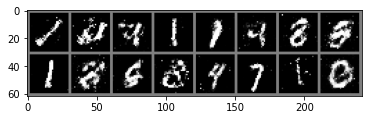

(epoch 111/200) p_real: 0.667444, p_g: 0.334841
(epoch 112/200) p_real: 0.627744, p_g: 0.295082
(epoch 113/200) p_real: 0.630112, p_g: 0.318854
(epoch 114/200) p_real: 0.641293, p_g: 0.321582
(epoch 115/200) p_real: 0.674041, p_g: 0.335810
(epoch 116/200) p_real: 0.629671, p_g: 0.299768
(epoch 117/200) p_real: 0.652637, p_g: 0.340107
(epoch 118/200) p_real: 0.611208, p_g: 0.292414
(epoch 119/200) p_real: 0.664608, p_g: 0.306896
(epoch 120/200) p_real: 0.665453, p_g: 0.312120


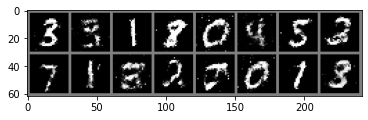

(epoch 121/200) p_real: 0.665123, p_g: 0.301603
(epoch 122/200) p_real: 0.667677, p_g: 0.305040
(epoch 123/200) p_real: 0.638233, p_g: 0.297145
(epoch 124/200) p_real: 0.650323, p_g: 0.328172
(epoch 125/200) p_real: 0.677342, p_g: 0.310596
(epoch 126/200) p_real: 0.631629, p_g: 0.293858
(epoch 127/200) p_real: 0.621588, p_g: 0.285535
(epoch 128/200) p_real: 0.661465, p_g: 0.415046
(epoch 129/200) p_real: 0.608316, p_g: 0.262243
(epoch 130/200) p_real: 0.639291, p_g: 0.348052


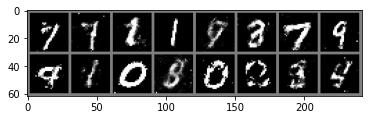

(epoch 131/200) p_real: 0.639753, p_g: 0.354548
(epoch 132/200) p_real: 0.633269, p_g: 0.317161
(epoch 133/200) p_real: 0.611823, p_g: 0.260002
(epoch 134/200) p_real: 0.603925, p_g: 0.289458
(epoch 135/200) p_real: 0.643518, p_g: 0.314703
(epoch 136/200) p_real: 0.600644, p_g: 0.271267
(epoch 137/200) p_real: 0.651086, p_g: 0.317393
(epoch 138/200) p_real: 0.601761, p_g: 0.297286
(epoch 139/200) p_real: 0.626915, p_g: 0.332813
(epoch 140/200) p_real: 0.616311, p_g: 0.314912


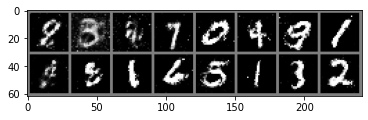

(epoch 141/200) p_real: 0.612608, p_g: 0.256899
(epoch 142/200) p_real: 0.605985, p_g: 0.292525
(epoch 143/200) p_real: 0.595877, p_g: 0.272776
(epoch 144/200) p_real: 0.649513, p_g: 0.336424
(epoch 145/200) p_real: 0.635271, p_g: 0.349472
(epoch 146/200) p_real: 0.642096, p_g: 0.293370
(epoch 147/200) p_real: 0.611962, p_g: 0.278068
(epoch 148/200) p_real: 0.628872, p_g: 0.312834
(epoch 149/200) p_real: 0.578128, p_g: 0.271525
(epoch 150/200) p_real: 0.623835, p_g: 0.287033


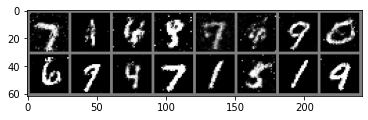

(epoch 151/200) p_real: 0.624608, p_g: 0.285396
(epoch 152/200) p_real: 0.631202, p_g: 0.338107
(epoch 153/200) p_real: 0.597670, p_g: 0.277498
(epoch 154/200) p_real: 0.636096, p_g: 0.324572
(epoch 155/200) p_real: 0.612517, p_g: 0.294275
(epoch 156/200) p_real: 0.592358, p_g: 0.283977
(epoch 157/200) p_real: 0.621445, p_g: 0.338688
(epoch 158/200) p_real: 0.599539, p_g: 0.278626
(epoch 159/200) p_real: 0.601136, p_g: 0.304102
(epoch 160/200) p_real: 0.584256, p_g: 0.222707


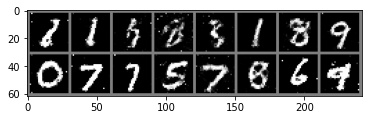

(epoch 161/200) p_real: 0.640236, p_g: 0.263893
(epoch 162/200) p_real: 0.627625, p_g: 0.309988
(epoch 163/200) p_real: 0.669641, p_g: 0.328945
(epoch 164/200) p_real: 0.608504, p_g: 0.281599
(epoch 165/200) p_real: 0.644053, p_g: 0.281338
(epoch 166/200) p_real: 0.610319, p_g: 0.307249
(epoch 167/200) p_real: 0.642076, p_g: 0.344943
(epoch 168/200) p_real: 0.590621, p_g: 0.302066
(epoch 169/200) p_real: 0.622302, p_g: 0.323843
(epoch 170/200) p_real: 0.603354, p_g: 0.322910


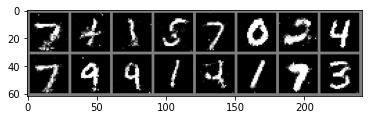

(epoch 171/200) p_real: 0.632080, p_g: 0.295597
(epoch 172/200) p_real: 0.613227, p_g: 0.337128
(epoch 173/200) p_real: 0.624187, p_g: 0.249879
(epoch 174/200) p_real: 0.613637, p_g: 0.327856
(epoch 175/200) p_real: 0.588433, p_g: 0.258032
(epoch 176/200) p_real: 0.610781, p_g: 0.327560
(epoch 177/200) p_real: 0.617567, p_g: 0.333682
(epoch 178/200) p_real: 0.631804, p_g: 0.346910
(epoch 179/200) p_real: 0.644530, p_g: 0.342220
(epoch 180/200) p_real: 0.619913, p_g: 0.264048


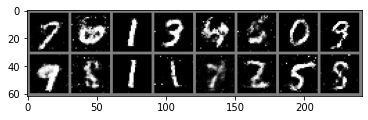

(epoch 181/200) p_real: 0.608219, p_g: 0.268212
(epoch 182/200) p_real: 0.618912, p_g: 0.326534
(epoch 183/200) p_real: 0.575670, p_g: 0.249036
(epoch 184/200) p_real: 0.636692, p_g: 0.324425
(epoch 185/200) p_real: 0.619248, p_g: 0.309305
(epoch 186/200) p_real: 0.622020, p_g: 0.296355
(epoch 187/200) p_real: 0.634534, p_g: 0.303874
(epoch 188/200) p_real: 0.601366, p_g: 0.244331
(epoch 189/200) p_real: 0.574674, p_g: 0.231556
(epoch 190/200) p_real: 0.619923, p_g: 0.316698


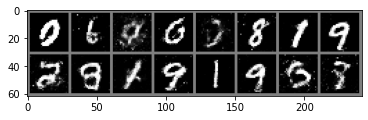

(epoch 191/200) p_real: 0.597752, p_g: 0.292195
(epoch 192/200) p_real: 0.646910, p_g: 0.288072
(epoch 193/200) p_real: 0.606744, p_g: 0.317409
(epoch 194/200) p_real: 0.590740, p_g: 0.286546
(epoch 195/200) p_real: 0.608494, p_g: 0.327473
(epoch 196/200) p_real: 0.596546, p_g: 0.263128
(epoch 197/200) p_real: 0.625293, p_g: 0.357053
(epoch 198/200) p_real: 0.603073, p_g: 0.292921
(epoch 199/200) p_real: 0.596684, p_g: 0.289864
(epoch 200/200) p_real: 0.645151, p_g: 0.296098


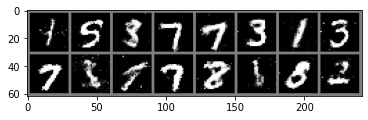

In [9]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):

    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
    #imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))
    if((epoch+1)% 10 == 0):
        #print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

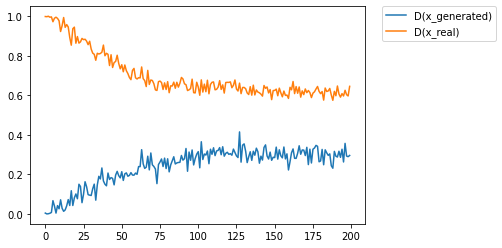

In [10]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

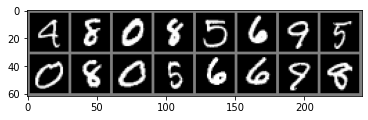

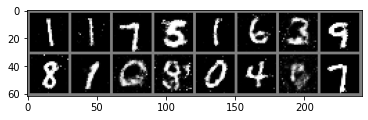

In [11]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))